In [1]:
import numpy as np
import pandas as pd

def sample_data():
    train_df = pd.read_csv('train.csv')
    return train_df

sample_data().head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [2]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
town_encoder = OneHotEncoder()
flat_type_encoder = OneHotEncoder()
flat_model_encoder = OneHotEncoder()
planning_area_encoder = OneHotEncoder()
region_encoder = OneHotEncoder()

def preprocess_region(df, is_train):
    col = "region"
    data = np.array(df[col]).reshape(-1, 1)
    if is_train:
        data = region_encoder.fit_transform(data)
    else:
        data = region_encoder.transform(data) 

    n = data.shape[1]
    tmp_df = pd.DataFrame(data.toarray(), columns=[f"{col}-{i}" for i in range(n)])  

    df = pd.concat([df.reset_index(drop=True), tmp_df.reset_index(drop=True)], axis=1)
    df = df.drop(columns=[col])
    return df

def preprocess_flat_type(df, is_train):
    col = "flat_type"
    data = np.array(df[col]).reshape(-1, 1)
    if is_train:
        data = flat_type_encoder.fit_transform(data)
    else:
        data = flat_type_encoder.transform(data) 

    n = data.shape[1]
    tmp_df = pd.DataFrame(data.toarray(), columns=[f"{col}-{i}" for i in range(n)])  

    df = pd.concat([df.reset_index(drop=True), tmp_df.reset_index(drop=True)], axis=1)
    df = df.drop(columns=[col])
    return df

def preprocess_flat_model(df, is_train):
    col = "flat_model"
    data = np.array(df[col]).reshape(-1, 1)
    if is_train:
        data = flat_model_encoder.fit_transform(data)
    else:
        data = flat_model_encoder.transform(data) 

    n = data.shape[1]
    tmp_df = pd.DataFrame(data.toarray(), columns=[f"{col}-{i}" for i in range(n)])  

    df = pd.concat([df.reset_index(drop=True), tmp_df.reset_index(drop=True)], axis=1)
    df = df.drop(columns=[col])
    return df

def preprocess_rent_approval_date(df, is_train):
    col = "rent_approval_date"
    df[[f'{col}-year', f'{col}-month']] = df[col].str.split('-', expand=True)
    df[f'{col}-year'] = df[f'{col}-year'].astype(int)
    df[f'{col}-month'] = df[f'{col}-month'].astype(int)
    df = df.drop(columns=[col])           
    return df

def create_geo_df(df):
    geo_coords = [Point(lon,lat) for lon,lat in zip(df["longitude"], df["latitude"])]
    geo_coords_df = gpd.GeoDataFrame({"geometry": geo_coords}, crs="EPSG:4326")
    geo_coords_df = geo_coords_df.to_crs(epsg=3414)
    geo_coords = np.array(geo_coords_df.geometry.apply(lambda point: (point.x, point.y)).tolist())
    return geo_coords

def preprocess_schools(df, radius_m):
    col = "n_schools"
    df_schools = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
    school_geo_coords = create_geo_df(df_schools)
    house_geo_coords = create_geo_df(df)

    tree = BallTree(school_geo_coords, leaf_size=20)    
    counts = tree.query_radius(house_geo_coords, r=radius_m, count_only=True)
    df[col] = counts
    return df

def preprocess_malls(df, radius_m):
    col = "n_malls"
    df_schools = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
    school_geo_coords = create_geo_df(df_schools)
    house_geo_coords = create_geo_df(df)

    tree = BallTree(school_geo_coords, leaf_size=20)    
    counts = tree.query_radius(house_geo_coords, r=radius_m, count_only=True)
    df[col] = counts
    return df

def preprocess_mrt_exisiting(df, radius_m):
    col = "n_mrt_existing"
    df_schools = pd.read_csv('auxiliary-data/sg-mrt-existing-stations.csv')
    school_geo_coords = create_geo_df(df_schools)
    house_geo_coords = create_geo_df(df)

    tree = BallTree(school_geo_coords, leaf_size=20)    
    counts = tree.query_radius(house_geo_coords, r=radius_m, count_only=True)
    df[col] = counts
    return df

def preprocess_mrt_planned(df, radius_m):
    col = "n_mrt_planned"
    df_schools = pd.read_csv('auxiliary-data/sg-mrt-planned-stations.csv')
    school_geo_coords = create_geo_df(df_schools)
    house_geo_coords = create_geo_df(df)

    tree = BallTree(school_geo_coords, leaf_size=20)    
    counts = tree.query_radius(house_geo_coords, r=radius_m, count_only=True)
    df[col] = counts
    return df

def drop_columns(df):
    df = df.drop(columns=['furnished', 'elevation', 'town', 'block', 'street_name', 'planning_area', 'subzone'])
    return df


def preprocess(df, is_train):
    # Without Auxilary Data: 486.65105
    df = preprocess_region(df, is_train)
    df = preprocess_rent_approval_date(df, is_train)
    df = preprocess_flat_type(df, is_train)
    df = preprocess_flat_model(df, is_train)
    df = drop_columns(df)

    # With Auxilary Data: 486.53359
    df = preprocess_schools(df, radius_m=2000)
    df = preprocess_malls(df, radius_m=2000)
    df = preprocess_mrt_exisiting(df, radius_m=2000)

    # With Auxiliary Data Of Planned MRT: 488.44957
    # df = preprocess_mrt_planned(df, radius_m=2000)
    return df

def scale(data, is_train):
    if is_train:
        return scaler.fit_transform(data)
    else:
        return scaler.transform(data)

def load_data(apply_split=True):
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    X_train, y_train = train_df.drop('monthly_rent', axis=1), train_df[['monthly_rent']]
    X_test = test_df
    if apply_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        X_train = preprocess(X_train, True)   
        X_val = preprocess(X_val, False)    
        X_test = preprocess(X_test, False)  

        feature_names = X_train.columns

        X_train = X_train.to_numpy()
        X_val = X_val.to_numpy()
        X_test = X_test.to_numpy()

        X_train = scale(X_train, True)
        X_val = scale(X_val, False)
        X_test = scale(X_test, False)

        y_train = y_train["monthly_rent"].to_numpy()
        y_val = y_val["monthly_rent"].to_numpy()
        return X_train, y_train, X_val, y_val, X_test, feature_names
    else:
        X_train = preprocess(X_train, True)   
        X_test = preprocess(X_test, False)    

        feature_names = X_train.columns

        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()

        X_train = scale(X_train, True)
        X_test = scale(X_test, False)

        y_train = y_train["monthly_rent"].to_numpy()
        return X_train, y_train, X_test, feature_names

X_train, y_train, X_val, y_val, X_test, feature_names = load_data()
X_train.shape

(48000, 42)

In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


def train_baseline_model(X_train, y_train, X_val, y_val, X_test, fname="submission.csv"):
    model = XGBRegressor()
    model.fit(X_train, y_train.reshape(-1, 1))

    y_pred = model.predict(X_val)
    print('Score: %.3f' % mean_squared_error(y_pred, y_val, squared=False))

    y_pred = model.predict(X_test)
    submission_df = pd.DataFrame({
        "Id": [i for i in range(len(y_pred))],
        "Predicted": y_pred,
    })
    submission_df.to_csv(fname, index=False, sep=",")
    return model

X_train, y_train, X_val, y_val, X_test, feature_names = load_data()
train_baseline_model(X_train, y_train, X_val, y_val, X_test)

Score: 489.642


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [4]:
X_train, y_train, X_test, feature_names = load_data(apply_split=False)
feature_names = feature_names.to_list()
model = train_baseline_model(X_train, y_train, X_train, y_train, X_test, fname="submission_full.csv")

Score: 446.775


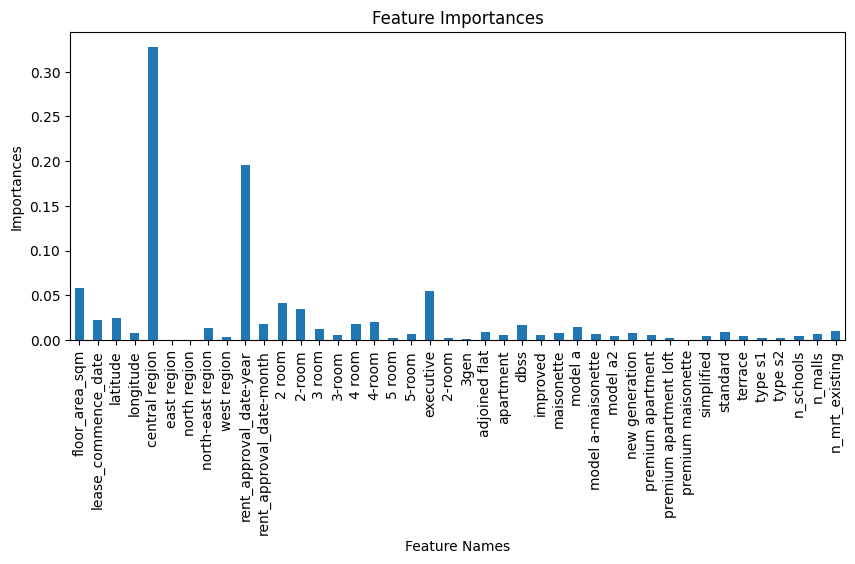

In [5]:
import matplotlib.pyplot as plt

for i, category in enumerate(region_encoder.categories_[0]):
    feature_name = f"region-{i}"
    idx = feature_names.index(feature_name)
    feature_names[idx] = category

for i, category in enumerate(flat_type_encoder.categories_[0]):
    feature_name = f"flat_type-{i}"
    idx = feature_names.index(feature_name)
    feature_names[idx] = category

for i, category in enumerate(flat_model_encoder.categories_[0]):
    feature_name = f"flat_model-{i}"
    idx = feature_names.index(feature_name)
    feature_names[idx] = category

plt.figure(figsize=(10, 4))
forest_importances = pd.Series(model.feature_importances_, index=feature_names)
forest_importances.plot.bar()
plt.title('Feature Importances')
plt.xlabel('Feature Names')
plt.ylabel('Importances')
plt.show()
